# 15.774/15.780 Fall 2023
# Recitation 3 - Logistic Regression & Data Cleaning
--------------------------------------------------------------------------------------------------------------------------------

First, we import the packages we will be using

In [1]:
# Install the packages you do not have
# !pip install sklearn

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline

---
## Logistic Regression - Customer Churn example

We will try to **build a model for correctly predicting the probability of customer churn**. 

Our dataset contains the following information: 
  * Information about 7,032 customers of an internet service company
  * Information on whether the customer churned or continues using the service (**1 if churnes, 0 otherwise**).
  * We also have 6 covariates available about the customers, including the monthly charges of the service, whether the cusromer is a senior citizen, the payment method, the internet service, the tenure in months, and the type of contract (monthly, yearly, etc.)


In [3]:
# Assuming 'customerchurn.csv' is in the same directory as your Python script or Jupyter Notebook
file_path = "customerchurn.csv"

# Use the read_csv function to load the CSV file into a DataFrame
churn = pd.read_csv(file_path)

churn.head()

,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,InternetService,tenure,Contract
0,0,29.85,0,Electronic check,DSL,1,Month-to-month
1,0,56.95,0,Mailed check,DSL,34,One year
2,1,53.85,0,Mailed check,DSL,2,Month-to-month
3,0,42.30,0,Bank transfer,DSL,45,One year
4,1,70.70,0,Electronic check,Fiber optic,2,Month-to-month


In [4]:
# First we split the dataset in train and test as we always do
# We use 70% of the data for training and 30% for test

np.random.seed(15774)
churn_train, churn_test = train_test_split(churn,train_size=0.7)

print("Train set shape:", churn_train.shape)
print("Test set shape:", churn_test.shape)

Train set shape: (4922, 7)
Test set shape: (2110, 7)


### Simple logistic regression (one feature)
We first run a simple logistic regression (simple meaning with only one covariate) of `Churn` on `MonthlyCharges`. We want to see the effect of the price of the service on churn.


In [5]:
# Define the dependent variable (y) and predictor variable (X)
y_train = churn_train["Churn"]
X_train = churn_train["MonthlyCharges"]

# Add a constant term to the predictor variable (intercept)
X_train = sm.add_constant(X_train)

# Fit the linear regression model
log_reg = sm.Logit(y_train, X_train).fit()

# Get the model summary
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.557812
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4920
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                 0.03449
Time:                        15:22:13   Log-Likelihood:                -2745.5
converged:                       True   LL-Null:                       -2843.6
Covariance Type:            nonrobust   LLR p-value:                 1.438e-44
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0931      0.089    -23.439      0.000      -2.268      -1.918
MonthlyCharges   

We observe a positive sign on price, meaning the higher the price of the service, the higher the probability of churn, which aligns with reality. We also see that both features are significant, but we do not see the actual value. Let us zoom in on the p-values.

In [6]:
log_reg.pvalues

const             1.704000e-121
MonthlyCharges     1.147174e-41
dtype: float64

The p-value of `MonthlyCharges` is basically 0. For any reasonable confidence level (e.g., 95%, 99%) the feature is relevant to predict churn.

**Note:** A big difference between linear regression and logistic regression is the possible interpretation of the coefficients. In linear regression, a coefficient $\beta\geq 0$ is interpreted as follows:

*If I increase my feature by 1 unit, the target variable will increase its value by $\beta$* 

However, logistic regression uses a non-linear transformation which makes that interpretation invalid. In logistic regression the sign is informative, but not the scale. Let's see how the interpretation fails.

We first compute the probability of churn for a customer that pays $\$30$ each month. We can do that directly with the logit function expression and the coefficients of the model we just trained. As we will use the logit expression several times we save its value on a lambda function

In [7]:
# Get the 'MonthlyCharges' and intercept ('const') coefficients
mcharges_coeff = log_reg.params["MonthlyCharges"]
intercept_coeff = log_reg.params["const"]

# Define your equation as a lambda function so that we can reuse it
churn_prob_equation = lambda x: np.exp(intercept_coeff + mcharges_coeff * x) / (1 + np.exp(intercept_coeff + mcharges_coeff * x))


Now we use it for `x=30`

In [8]:
churn_prob_equation(30)

0.16493552428176292

So there is a probability of 16% of churning if the monthly charges are $\$30$. Let's see what happens if the charges increase to $\$40$ or $\$50$. As those are 10 and 20 units of increase respectively, on a linear regression we expect $0.0157\times 10=0.157$ and $0.0157\times 20=0.314$ of increase in the probability. However, the increases we get are different

In [9]:
prob_increase_30_40 = churn_prob_equation(40) - churn_prob_equation(30)
print(f"Churn probability for $40: {churn_prob_equation(40)}")
print(f"Churn probability increase for $40: {prob_increase_30_40}")

prob_increase_30_50 = churn_prob_equation(50) - churn_prob_equation(30)
print(f"Churn probability for $50: {churn_prob_equation(50)}")
print(f"Churn probability increase for $50: {prob_increase_30_50}")

Churn probability for $40: 0.187718257816708
Churn probability increase for $40: 0.022782733534945088
Churn probability for $50: 0.21284587036840633
Churn probability increase for $50: 0.04791034608664341


There is a second way of computing the churn probabilities. We could have the probabilities of churn directly with the model's `predict` function instead. We can obtain probabilities of churn for the 3 values: 30, 40, and 50 within the same `predict` call.

In [10]:
# Prepare the test set with the 3 values 30, 40, 50
X_test = pd.DataFrame({"MonthlyCharges": [30, 40, 50]})

# Add a constant term to the predictor variable (intercept)
X_test = sm.add_constant(X_test)

# Predict the probabilities of default and report those values
log_reg.predict(X_test)

0    0.164936
1    0.187718
2    0.212846
dtype: float64

### Multiple logistic regression (more than one feature)

We now build a multiple logistic regression model that predicts `Churn` as a function of `MonthlyCharges`, `tenure`, and whether the contract is monthly. `Contract` is categorical, not numerical. We need to transform it into numerical variables. We define the one-hot-encoding of the  monthly contract

In [11]:
churn_train["is_monthly"] = (churn_train["Contract"] == "Month-to-month").astype("int")
churn_test["is_monthly"] = (churn_test["Contract"] == "Month-to-month").astype("int")


In [12]:
# Define the features of the model
features = ["MonthlyCharges", "tenure", "is_monthly"]

# Define the dependent variable (y) and predictor variable (X)
y_train = churn_train["Churn"]
X_train = churn_train[features]

# Add a constant term to the predictor variable (intercept)
X_train = sm.add_constant(X_train)

# Fit the linear regression model
mult_log_reg = sm.Logit(y_train, X_train).fit()

# Get the model summary
summary = mult_log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.438887
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4918
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.2403
Time:                        15:22:13   Log-Likelihood:                -2160.2
converged:                       True   LL-Null:                       -2843.6
Covariance Type:            nonrobust   LLR p-value:                4.592e-296
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.0148      0.150    -20.107      0.000      -3.309      -2.721
MonthlyCharges   

In [13]:
# Zoom-in on the actual p-values
mult_log_reg.pvalues

const             6.460557e-90
MonthlyCharges    1.638456e-71
tenure            2.424395e-49
is_monthly        9.372114e-34
dtype: float64

We see that `MonthlyCharges` still have a p-value close to 0. There is evidence that this variable is still significant, that is, with this variables, there is evidence that `MonthlyCharges` is relevant to predict churn probabilities.

### Logistic regression evaluation

Based on the cost structure of 2 for false positives and 8 for false negatives we got a probability threshold of $p=0.2$. We use that to evaluate both models. First, we get the confusion matrices for both

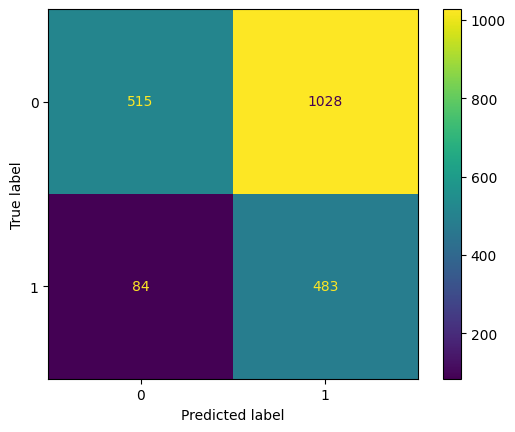

In [14]:
# Define the dependent variable (y) and predictor variable (X)
y_test = churn_test["Churn"]
X_test = churn_test["MonthlyCharges"]

# Add a constant term to the predictor variable (intercept)
X_test = sm.add_constant(X_test)

# Predict default probabilities with the model 
default_probs = log_reg.predict(X_test)

# Use the probability of p=0.2 to get the actual predictions
default_preds = (default_probs > 0.2)

# Compute and show the confusion matrix
cm = confusion_matrix(y_test, default_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

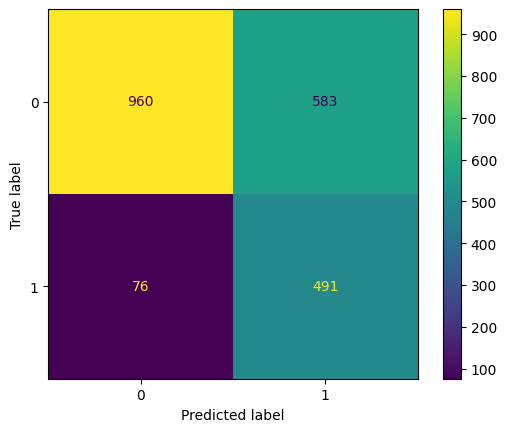

In [15]:
# Define the dependent variable (y) and predictor variable (X)
y_test = churn_test["Churn"]
features = ["MonthlyCharges", "tenure", "is_monthly"]
X_test = churn_test[features]

# Add a constant term to the predictor variable (intercept)
X_test = sm.add_constant(X_test)

# Predict default probabilities with the model 
default_probs = mult_log_reg.predict(X_test)

# Use the probability of p=0.2 to get the actual predictions
default_preds = (default_probs > 0.2)

# Compute and show the confusion matrix
cm = confusion_matrix(y_test, default_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

*** 
We compute now the following summary measures of performance for both models: 
* Accuracy
* Sensitivity (True Positive Rate)
* Specificity (True Negative Rate)

In [16]:
# Metrics for simple logistic regression
TN, FP = 515, 1028
FN, TP = 84, 483

ACC = (TN + TP) / (TN + FN + TP +FP) 
print(f"Accuracy: {ACC:.3f}")

TPR = TP / (TP + FN) 
print(f"Sensitivity (True Positive Rate): {TPR:.3f}")

TNR = TN / (TN + FP) 
print(f"Specificity (True Negative Rate): {TNR:.3f}")

Accuracy: 0.473
Sensitivity (True Positive Rate): 0.852
Specificity (True Negative Rate): 0.334


In [17]:
# Metrics for simple logistic regression
TN, FP = 960, 583
FN, TP = 76, 491

ACC = (TN + TP) / (TN + FN + TP +FP) 
print(f"Accuracy: {ACC:.3f}")

TPR = TP / (TP + FN) 
print(f"Sensitivity (True Positive Rate): {TPR:.3f}")

TNR = TN / (TN + FP) 
print(f"Specificity (True Negative Rate): {TNR:.3f}")

Accuracy: 0.688
Sensitivity (True Positive Rate): 0.866
Specificity (True Negative Rate): 0.622


**Comment:** All the metrics are better for the second model. Furthermore, all the features are significant, and the signs of the coefficients are realistic.

---
---
## Data Cleaning - Titanic dataset

In this problem, we will work with the Titanic Disaster dataset, a dataset that is used often in introductory ML and Data Science courses, competitions, and tutorials.

The features are the following:
* survival - Survival (0 = No; 1 = Yes)
* pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name - Name
* sex - Sex
* age - Age
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

We will use it to introduce you to different Missing Data and Outlier Detection techniques. We aim to **have a clean dataset so that we can use it for predicting whether a passenger survived or not based on their features**.


We first load the data.

In [18]:
# Assuming 'titanic.csv' is in the same directory as your Python script or Jupyter Notebook
file_path = "titanic.csv"

# Use the read_csv function to load the CSV file into a DataFrame
titanic = pd.read_csv(file_path)
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing data
We start by detecting missing data. In Python, missing data are represented with the identifier (or object) `NaN` which is an acronym for "Not a Number". There are several ways of detecting missing data. Here we will use the pandas function `.isna()` that returns true if the cell is missing and false otherwise

In [19]:
titanic.isna().head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False


We can see that `cabin` contains some missing values. In the other features we do not see missing data in the first 5 rows, but we should not conclude they do not have missing data yet. To have better metrics, we will use `.sum()` and `.mean()` which are functions of a DataFrame that respecively compute the sum and the average of each column. In this case, False is treated as 0 and True as 1, so with `sum` we are counting missing data for each column, and with `mean` we are computing the ratio of missing data.

In [20]:
# Get missing value counts
na_counts = titanic.isna().sum()

# Filter features that have missing values
na_counts[na_counts > 0]


age         177
cabin       690
embarked      2
dtype: int64

In [21]:
# Get missing value ratios
na_ratio = titanic.isna().mean()

# Filter features that have missing values
na_ratio[na_ratio > 0]

age         0.197987
cabin       0.771812
embarked    0.002237
dtype: float64

Now we can conclude that `age`, `cabin`, and `embarked` have missing data. We will treat this 3 columns in a different way.

#### Missing data in `embarked` - Removing rows

In this case, we have only 2 missing values. It is safe to filter out those rows

In [22]:
# Remove rows with missing data in embarked
titanic = titanic[~titanic.embarked.isna()]


#### Missing data in `cabin` - Creating relevant features

We observe that `cabin` has $77\%$ missing values. This is a considerable amount, and any imputation rule for this feature will be inaccurate. We have two options in this case. First, we can remove the feature completely and not use it in our model to predict survivals. As obnly $23\%$ of the passengers have this information, we might think that this variable is uninformative. However, we could also analyze why this data is missing. It might be the case that passengers without cabin information are 2nd and 3rd class passengers, and they actually did not have a cabin. Let's analyze that statement

In [23]:
# Filter data to obtain the rows of passengers with and without cabin information
pass_with_cabin = titanic[~titanic.cabin.isna()]
pass_without_cabin = titanic[titanic.cabin.isna()]

In [24]:
# Check counts per class
pass_with_cabin.pclass.value_counts()

pclass
1    174
2     16
3     12
Name: count, dtype: int64

In [25]:
# Check counts per class
pass_without_cabin.pclass.value_counts()

pclass
3    480
2    168
1     41
0      1
Name: count, dtype: int64

Our statement might not be completely true, but there is evidence in the data that it is a possibility. As we do not know whether this statement is correct, we have to see if this information is useful for the task in hand. In this case, we will analyze whether having or not cabin information is a good predictor for survival

In [26]:
# Check counts for survivors
pass_with_cabin.survived.value_counts()

survived
1    134
0     68
Name: count, dtype: int64

In [27]:
# Check counts for survivors
pass_without_cabin.survived.value_counts()

survived
0    483
1    207
Name: count, dtype: int64

We can see a relation. In this case, instead of completely removing the information of this variable, we first create a new feature that captures whether a passenger has cabin information

In [28]:
# Create the new variable
titanic["has_cabin_info"] = (titanic.cabin.isna() == False).astype(int)

# Remove cabin feature
del titanic["cabin"]

#### Missing data in `age` - Impute values

For this feature, we have approx. $20\%$ of missing values. Imputation is a great option and we will see different ways of imputing the data. When imputing data, we need to evaluate the different models to see which imputation methods work better. For that, we will use the MAPE metric.



In [29]:
# MAPE function
def compute_mape(y_true, y_pred):
    return (100 * abs((y_true - y_pred) / y_true)).mean()

We start with the two most basic models: **mean** and **median** age in the training set

In [30]:
# Keep first only the data that has values
titanic_no_nas = titanic[~titanic.age.isna()]

# Split the data in 80% train and 20% test
np.random.seed(15780)
titanic_no_nas_train, titanic_no_nas_test = train_test_split(titanic_no_nas, train_size=0.8)

# Build X and y for test and train
features = ["age"]
X_train = titanic_no_nas_train[features]
y_train = titanic_no_nas_train["age"]
X_test = titanic_no_nas_test[features]
y_test = titanic_no_nas_test["age"]

# Compute the mean crim in the train set
mean_age = X_train.age.mean()
print(f"Mean age: {mean_age}")

# Compute and report the MAPE
print(f"MAPE: {compute_mape(mean_age, y_test)}")

Mean age: 29.790944055944053
MAPE: 39.50277810464355


In [31]:
# Compute the median crim in the train set
median_age = X_train.age.median()
print(f"Median age: {median_age}")

# Compute and report the MAPE
print(f"MAPE: {compute_mape(mean_age, y_test)}")

Median age: 29.0
MAPE: 39.50277810464355


**Comment**: Both MAPEs are high: 39.5% and 40.2% respectively. The mean is slightly better, but both predictions are close.

Now we will impute `age` values using a **knn** model with 1, 3, and 10 neighbors respectively using other variables as descriptors. It's very important to note that `age` should not be included as a descriptor as we did in the previous part, as we will not have that information for the missing values. We should not use `survived` either, as this will be the target variable of our model. We will use `age` as a feature to predict `survived` later.

In [32]:
# Build X and y for test and train
features = ["pclass", "sibsp", "parch", "fare"]
X_train = titanic_no_nas_train[features]
y_train = titanic_no_nas_train["age"]
X_test = titanic_no_nas_test[features]
y_test = titanic_no_nas_test["age"]

# Define knn model with 3 neighbors and train it with the train data
knn_1 = KNeighborsRegressor(n_neighbors=1)
knn_1.fit(X_train, y_train)

# Predict crim
pred_1 = knn_1.predict(X_test)

# Compute and report MAPE
print(f"MAPE: {compute_mape(pred_1, y_test)}")

MAPE: 50.29475325206437


In [33]:
# Define knn model with 1 neighbors and train it with the train data
knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_3.fit(X_train, y_train)

# Predict crim
pred_3 = knn_3.predict(X_test)

# Compute and report MAPE
print(f"MAPE: {compute_mape(pred_3, y_test)}")

MAPE: 46.43409272212745


In [34]:
# Define knn model with 10 neighbors and train it with the train data
knn_10 = KNeighborsRegressor(n_neighbors=10)
knn_10.fit(X_train, y_train)

# Predict crim
pred_10 = knn_10.predict(X_test)

# Compute and report MAPE
print(f"MAPE: {compute_mape(pred_10, y_test)}")

MAPE: 35.21215642405437


**Comment**: MAPEs with knn are lower, and slightly better than the mean and median models. The best imputation is obtained for 10 neighbors with a MAPE of $35\%$.

Let us now impute the age with the model `knn_10`

In [35]:
# Get the rows that need to be imputed
titanic_no_nas = titanic[titanic.age.isna()]

# Get the predictor features
features = ["pclass", "sibsp", "parch", "fare"]
X_no_nas = titanic_no_nas[features]

# Get the imputed values from the knn_10 model
imp_values = knn_10.predict(X_no_nas)

# Impute them in the original set
titanic.age[titanic.age.isna()] = imp_values

/var/folders/6s/g7kdrt6j3q32cg46j9q_hxpm0000gn/T/ipykernel_16051/633896082.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic.age[titanic.age.isna()] = imp_values


Finally, we check that we don not have missing values in our data

In [36]:
titanic.isna().sum()

survived          0
pclass            0
name              0
sex               0
age               0
sibsp             0
parch             0
ticket            0
fare              0
embarked          0
has_cabin_info    0
dtype: int64

### Outlier detection

Let us try to find some outliers in the current variables. A complete analysis would go through all the features, but we will focus on `fare`. 

We start by looking at the data distribution. For that we can use histograms and boxplots.


<Axes: ylabel='Frequency'>

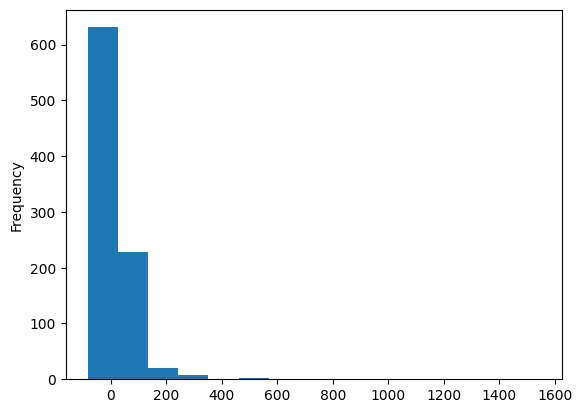

In [37]:
# Use a histogram to detect outliers
titanic.fare.plot.hist(bins=15)

<Axes: >

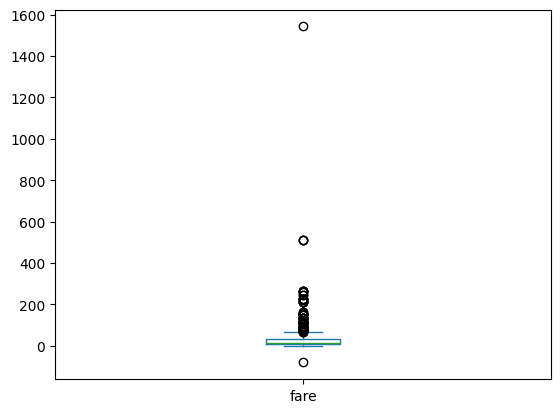

In [38]:
# Use a box plot to detect the outliers
titanic.fare.plot.box()

With the box plot we can spot two potential problems. The first one is that there is one or more samples with a negative fare, which is not realistic, and the second one is samples with fares around 500 and 1500, which are isolated from the usual distributions. Let us analyze those samples. The histogram plot could spot the negative fares, and the samples with fare around 500. It is hard to see the samples with a fare of 1500

Let us first analyze the negative fares

In [39]:
titanic[titanic.fare < 0]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,has_cabin_info
227,1,1,"Johnson, Mr. Robert",male,45.0,0,0,463847,-80.5,S,0


We see an adult male that had a negative fare. Having a negative fare is not realistic, but the scale of the number might be correct. We could fix the value by removing the negative sign. However, we need to see if this correction makes sense in terms of the distributions. Let us see if a fare of 80.5 is realistic

In [40]:
# Compute some statistics for positive fares
positive_fares = titanic[titanic.fare > 0].fare

positive_fares.describe(percentiles=np.arange(0,1,0.1))

count     875.000000
mean       34.373793
std        71.406442
min         4.012500
0%          4.012500
10%         7.734980
20%         7.895800
30%         8.050000
40%        11.133300
50%        14.500000
60%        23.000000
70%        27.720800
80%        39.775000
90%        77.958300
max      1543.120000
Name: fare, dtype: float64

80.5 is not close to the mean or the median. The value is in the percentile $90\%$. It may seem that it is not a realistic value within the fares distribution. However, we can see that the passenger is in first class, for which fares are higher. Let us compute statistics for fares within the first class passengers

In [41]:
# Compute the mean and median fare for positive fares
positive_fares_1st_class = positive_fares[titanic.pclass == 1]

positive_fares_1st_class.describe(percentiles=np.arange(0,1,0.1))

count    209.000000
mean      86.207715
std       78.584940
min        5.000000
0%         5.000000
10%       26.550000
20%       30.300000
30%       39.480000
40%       52.554200
50%       61.379200
60%       78.266700
70%       88.062520
80%      115.965000
90%      164.866700
max      512.329200
Name: fare, dtype: float64

Now the value is in percentile $60\%$ and close to the mean. It is reasonable to think there was an error and we can correct the value.

In [42]:
titanic.fare[titanic.fare < 0] = -titanic.fare[titanic.fare < 0]

/var/folders/6s/g7kdrt6j3q32cg46j9q_hxpm0000gn/T/ipykernel_16051/88356981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic.fare[titanic.fare < 0] = -titanic.fare[titanic.fare < 0]


In [43]:
# Check the fix. Passenger had index 227
titanic.loc[[227] ,:]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,has_cabin_info
227,1,1,"Johnson, Mr. Robert",male,45.0,0,0,463847,80.5,S,0


Now we focus on the high values around 500 and 1500

In [44]:
titanic[titanic.fare > 500]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,has_cabin_info
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,0
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,1
718,0,3,"Johnson, Alice",female,25.0,2,1,33567,1543.1200,Q,0
739,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,1


The rows with fare arounf 500 have the same ticket, same class, similar age, and embarked in the same location. The fare is high, but it is a first class ticket. We could assume those values are correct. However, the fare around 1500 comes from a third class ticket which has a very unrealistic value. We can analyze again if we could divide the value by 10 or 100 and see if the value is correct, but in this case we will simply remove the row.

In [45]:
titanic = titanic[titanic.fare < 1000]

### Predict survival probability with the clean data and a logistic regression

In [46]:
# Split the data in 80% train and 20% test
np.random.seed(15774)
titanic_train, titanic_test = train_test_split(titanic, train_size=0.8)

# Split data in predictors (X) and target (y)
features = ["pclass", "age", "sibsp", "parch", "fare", "has_cabin_info"]
X_train = titanic_train[features]
X_train = sm.add_constant(X_train)
y_train = titanic_train["survived"]

X_test = titanic_test[features]
X_test = sm.add_constant(X_test)
y_test = titanic_test["survived"]

# Train a multiple logistic regression
mult_log_reg = sm.Logit(y_train, X_train).fit()

# Get the model summary
summary = mult_log_reg.summary()
print(summary)


Optimization terminated successfully.
         Current function value: 0.583392
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.1152
Time:                        15:22:14   Log-Likelihood:                -415.38
converged:                       True   LL-Null:                       -469.47
Covariance Type:            nonrobust   LLR p-value:                 4.862e-21
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9935      0.537      3.715      0.000       0.942       3.045
pclass           

Assume we had a cost structure from which we obtained **p=0.3** and let us evaluate our model

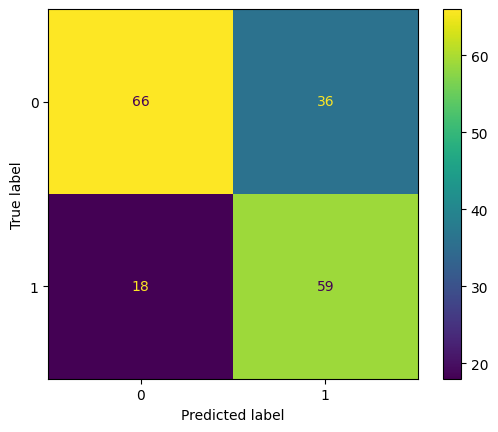

In [47]:
# Predict default probabilities with the model 
default_probs = mult_log_reg.predict(X_test)

# Use the probability to get the actual predictions
# We assume we computed the probability based on some cost structure 
default_preds = (default_probs > 0.3)

# Compute and show the confusion matrix
cm = confusion_matrix(y_test, default_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [48]:
# Metrics for simple logistic regression
(TN, FP), (FN, TP) = cm

ACC = (TN + TP) / (TN + FN + TP +FP) 
print(f"Accuracy: {ACC:.3f}")

TPR = TP / (TP + FN) 
print(f"Sensitivity (True Positive Rate): {TPR:.3f}")

TNR = TN / (TN + FP) 
print(f"Specificity (True Negative Rate): {TNR:.3f}")

Accuracy: 0.698
Sensitivity (True Positive Rate): 0.766
Specificity (True Negative Rate): 0.647


---
*End of Recitation 3*